# Subpolar gyre analysis

In this notebook, we perform an anlaysis of the subpolar gyre, including different areas of barotropic vorticity budget integrations.

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

from gsw import sigma2, SA_from_SP, p_from_z, rho

import cosima_cookbook as cc
import gcm_filters
import os

import cartopy.feature as cfeature

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:36883' processes=7 threads=28, memory=251.19 GiB>

In [3]:
start_time, end_time = '2001-01-01', '2100-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
ρ0 = 1035

var_name = 'beta_v'
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

In [4]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_names = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
             'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
             'Monthly_mean_BVB_MOM6-SIS2_RYF_control', 
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt = ['mom6-om4-025-RYF-negativeNAO-2.0', 
        'mom6-om4-025-RYF-negativeNAO-1.0', 
        'mom6-om4-025-RYF-control', 
        'mom6-om4-025-RYF-positiveNAO-1.0',
        'mom6-om4-025-RYF-positiveNAO-2.0']

db = '/scratch/x77/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

In [5]:
x_min_subpolar, x_max_subpolar = -63, -10
y_min_subpolar, y_max_subpolar = 40, 67

The notebook `Snapshot-EOF-both-gyres.ipynb` explains dynamically distinct regions for both the subtropical and subpolar gyre using a snapshot EOF analysis. We find weak anomalies in the interor subtropical gyre and strong in the Gulf Stream. We anticipate that the differences in magnitude of anomalies could be linked to different dynamics playing a dominant role in each region. Before that, we plot the time series of gyre strength for both the interior and in the Gulf Stream.

## Time series of barotropic streamfunction

In [6]:
def da_north_atlantic_mask_vmo(da):
    ht = cc.querying.getvar(expt[2], 'deptho', session, n = -1)
    ht = grid.interp(ht, 'X', boundary = 'fill')
    ht = grid.interp(ht, 'Y', boundary = 'fill')
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yq < -34)).fillna(0)
    indo_map1 = (land_mask.where(land_mask.yq < 9).where(land_mask.yq > -34).where(land_mask.xq > -280).where(land_mask.xq < -65)).fillna(0)
    indo_map2 = (land_mask.where(land_mask.yq < 15).where(land_mask.yq > 9).where(land_mask.xq > -280).where(land_mask.xq < -83.7)).fillna(0)
    indo_map3 = (land_mask.where(land_mask.yq < 17).where(land_mask.yq > 15).where(land_mask.xq > -280).where(land_mask.xq < -93.3)).fillna(0)
    indo_map4 = (land_mask.where(land_mask.yq < 85).where(land_mask.yq > 17).where(land_mask.xq > -280).where(land_mask.xq < -99)).fillna(0)
    indo_map5 = (land_mask.where(land_mask.yq < 30.5).where(land_mask.yq > -34).where(land_mask.xq > 25).where(land_mask.xq < 80)).fillna(0)
    
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map > 0)
    
    north_atlantic_sector_mask = atlantic_sector_mask.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
    return da * north_atlantic_sector_mask

In [7]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])

vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)

We define the gyre strength as a percentile of barotropic transport by considering a subset of the North Atlantic Ocean.

Text(0.5, 1.0, 'Strength of western region')

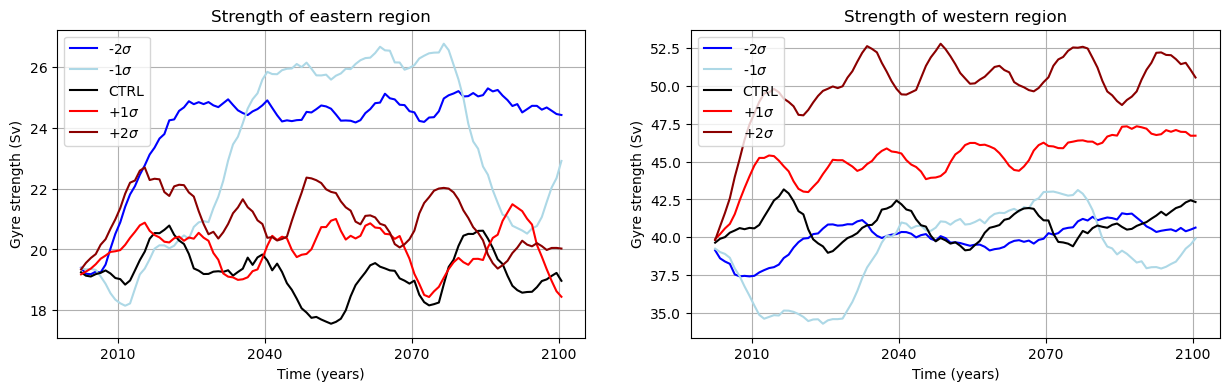

In [8]:
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu = da_north_atlantic_mask_vmo(area_bu)
area_bu = area_bu.where(~np.isnan(vmo_2d_itp.isel(time = 0))).fillna(0)
area_bu_normalize = preprocessing.normalize(area_bu)
quan_vals = [0.75, 0.95]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
for i, expt_name in enumerate(dir_names):
    umo_2d = cc.querying.getvar(expt[i], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = cc.querying.getvar(expt[i], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                                end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    
    grid_data = xr.merge((umo_2d, vmo_2d))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
    Ψ = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
    Ψ = Ψ.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).coarsen(time = 12).mean()
    Ψ = (- 1 * Ψ).chunk(chunks = {'xq':-1, 'yq':-1})
    for j, quantile in enumerate(quan_vals):
        Ψ_ts = Ψ.weighted(area_bu).quantile(quantile, dim = {"yq", "xq"})
        Ψ_ts.rolling(time = 5, min_periods = 2).mean().plot(label = expt_labels[i], color = color_values[i], ax = axes[j])

for j in range(2):
    axes[j].legend()
    axes[j].grid()
    axes[j].set_xlabel('Time (years)')
    axes[j].set_ylabel('Gyre strength (Sv)')
axes[0].set_title('Strength of eastern region')
axes[1].set_title('Strength of western region')

It is interesting that the 75th percentile gyre strength, which captures the eastern subpolar gyre's streamfunction, increases for both negative and positive NAO phase experiments. For the western regions (Labrador and Irminger Seas), the streamfunction plots show a similar story -- the gyre strength stays constant for the negative NAO phase experiments, while it increases for the positive NAO phase experiments. 

To check whether this value correctly represents the subpolar gyre, we plot the contour level for the control simulation.

In [9]:
Ψ_NA_tmean = Ψ_NA.mean('time').load()
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu_NA = da_north_atlantic_mask_vmo(area_bu)
area_bu_NA = area_bu_NA.where(~np.isnan(Ψ_NA_tmean))

Text(0.5, 1.0, 'Barotropic streamfunction')

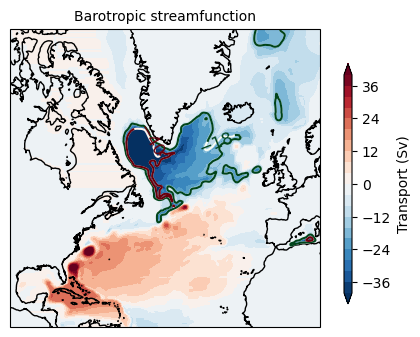

In [10]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

ϵ = 1e-5
p1 = axes.contourf(Ψ_NA.xq, Ψ_NA.yq, Ψ_NA_tmean, levels = np.linspace(-40, 40, 21), 
            cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes.contour(Ψ_NA.xq, Ψ_NA.yq, Ψ_NA_tmean, levels = np.linspace(-18 - ϵ, -18, 2), 
            cmap = 'Greens', transform = ccrs.PlateCarree(), extend = 'both')
p3 = axes.contour(Ψ_NA.xq, Ψ_NA.yq, Ψ_NA_tmean, levels = np.linspace(-40 - ϵ, -40, 2), 
            cmap = 'Reds', transform = ccrs.PlateCarree(), extend = 'both', color = 'black')

axes.clabel(p2, levels = [-18], fontsize = 12)
axes.clabel(p3, levels = [-40], fontsize = 12)

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Transport (Sv)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')

axes.set_title('Barotropic streamfunction', fontsize = 10)

### A small detour: is AMOC strength correlated with the gyre strength?

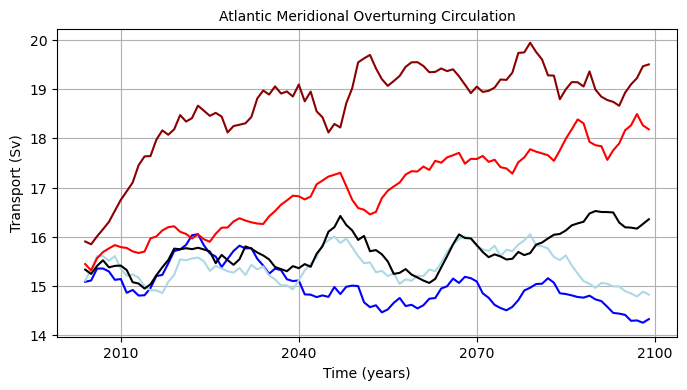

In [11]:
start_time, end_time = '2001-01-01', '2100-12-31'

plt.figure(figsize = (8, 4))
for i, expt_name in enumerate(dir_names):
    psi_amoc = cc.querying.getvar(expt[i], 'vmo', session = session, frequency = '1 yearly', use_cftime = True, start_time = start_time, end_time = end_time, attrs = {"cell_methods": "rho2_l:sum yq:point xh:sum time: mean"}, chunks = {}).sel(
        xh = slice(-103, -5)).sum('xh').sel(method = 'Nearest', yq = 26) * 1.0e-9
    psi_amoc = psi_amoc.sel(time = slice(start_time, end_time))
    psi_amoc_sum = psi_amoc.cumsum('rho2_l') - psi_amoc.sum('rho2_l')
    psi_amoc_sum = psi_amoc_sum.sel(rho2_l = slice(1035.5, None)).max('rho2_l').resample(time = 'Y').mean()
    psi_amoc_sum.rolling(time = 5, center = True).mean().dropna("time").plot(color = color_values[i])
    plt.xlabel('Time (years)')
    plt.ylabel('Transport (Sv)')
    plt.title('Atlantic Meridional Overturning Circulation', fontsize = 10)

plt.grid()

## Taking -10 Sv contour as mask

Text(0.5, 1.0, 'Subpolar gyre area integration')

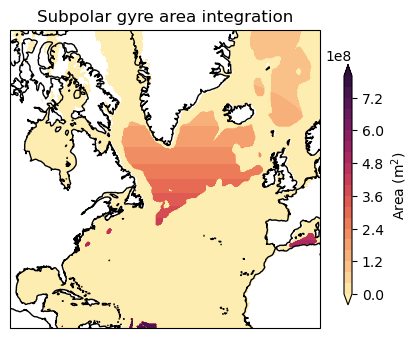

In [10]:
cutoff_contour = -10 ## in Sverdrups

projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

mask_neg10 = xr.where(Ψ_NA_tmean <= cutoff_contour, 1, 0)
area_subpolar = area_bu_NA * mask_neg10
p1 = axes.contourf(area_subpolar.xq, area_subpolar.yq, area_subpolar, levels = np.linspace(0, 8e8, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both', color = 'black')

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Area (m$^2$)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')
axes.set_title('Subpolar gyre area integration')

In [11]:
## One edge case remains, where the function encounters 3 alternating values, like 1, 0, 1.
## Another edge case is when the cutoff contour is close to zero.

def mask_interpolation_transect(Ψ, y_sel, zero_precedes_one, one_precedes_zero, cutoff_contour, old_mask, gyre_type):

    ## This is the original mask
    new_mask = old_mask.copy(deep = True)

    ## We create a streamfunction transect with values greater/smaller than the cutoff transport
    if(gyre_type == 'subtropical'):
        Ψ_cutoff = Ψ.where(Ψ >=cutoff_contour).dropna('xq').load()
    elif(gyre_type == 'subpolar'):
        Ψ_cutoff = Ψ.where(Ψ <=cutoff_contour).dropna('xq').load()

    ## Checking if there are any values to interpolate (true for latitudes where the streamfunction is weaker than the cutoff for all longitudes)
    if(Ψ_cutoff.shape[0] == 0):  
        return old_mask, old_mask
    
    if(zero_precedes_one.shape[0] > 0):
        for i in zero_precedes_one:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values

            #print(new_mask.sel(xq = x_west, method = 'nearest').values)
            #print(new_mask.sel(xq = x_east, method = 'nearest').values)

            if (np.isnan(Ψ_west.item()) or np.isnan(Ψ_east.item())):
                continue

            #if (new_mask.sel(xq = x_west, method = 'nearest').values.item() == 0 and new_mask.sel(xq = x_east, method = 'nearest').values.item() == 1):
            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = (x_east - x_mid)/(x_east - x_west)
            new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)

    if(one_precedes_zero.shape[0] > 0):
        for i in one_precedes_zero:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values

            if (np.isnan(Ψ_west.item()) or np.isnan(Ψ_east.item())):
                continue

            #if (new_mask.sel(xq = x_east, method = 'nearest').values.item() == 0 and new_mask.sel(xq = x_west, method = 'nearest').values.item() == 1):
            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = 1 - (x_east - x_mid)/(x_east - x_west)
            new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)
        
    return old_mask, new_mask

def mask_with_interpolation(Ψ, old_mask_total, cutoff_contour, gyre_type, y_min_bound = None, y_max_bound = None):
           
    for y_sel in Ψ.yq.sel(yq = slice(y_min_bound, y_max_bound)).values:
        Ψ_ysel = Ψ.sel(yq = y_sel, method = 'nearest')
        old_mask = old_mask_total.sel(yq = y_sel, method = 'nearest')

        zero_precedes_one = np.where((old_mask.values[:-1] == 0) & (old_mask.values[1:] == 1))[0]
        one_precedes_zero = np.where((old_mask.values[:-1] == 1) & (old_mask.values[1:] == 0))[0]
        old_mask, new_mask = mask_interpolation_transect(Ψ_ysel, y_sel, zero_precedes_one, one_precedes_zero, cutoff_contour, old_mask, gyre_type)

        if(y_sel == Ψ.yq[0].item()):
            new_mask_total = new_mask
        else:
            new_mask_total = xr.concat([new_mask_total, new_mask], dim = 'yq')

    return new_mask_total

In [12]:
mask_neg10_subset = mask_neg10.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).load()
Ψ_NA_tmean_subset = Ψ_NA_tmean.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).load()

cutoff_whole = -10
mask_neg10_improved = mask_with_interpolation(Ψ_NA_tmean_subset, mask_neg10_subset, cutoff_whole, 'subpolar', y_min_bound = None, y_max_bound = None)

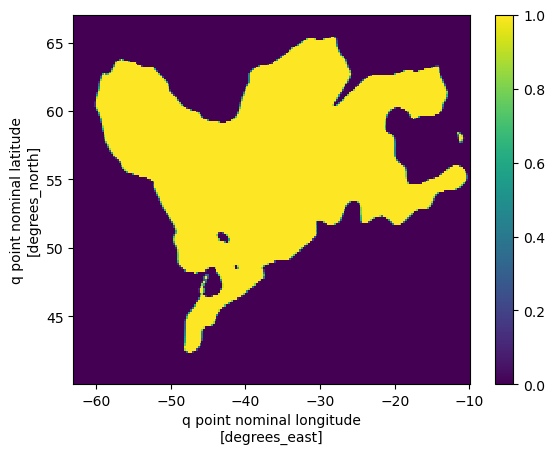

In [15]:
mask_neg10_improved.plot()

Text(0.5, 1.0, 'Difference between original and interpolated mask')

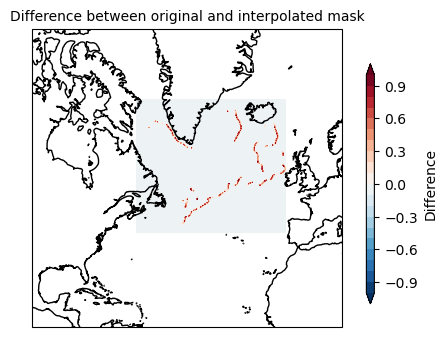

In [16]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

p1 = axes.contourf(mask_neg10_subset.xq, mask_neg10_subset.yq, mask_neg10_improved - mask_neg10_subset, levels = np.linspace(-1, 1, 21), 
            cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Difference', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')

axes.set_title('Difference between original and interpolated mask', fontsize = 10)

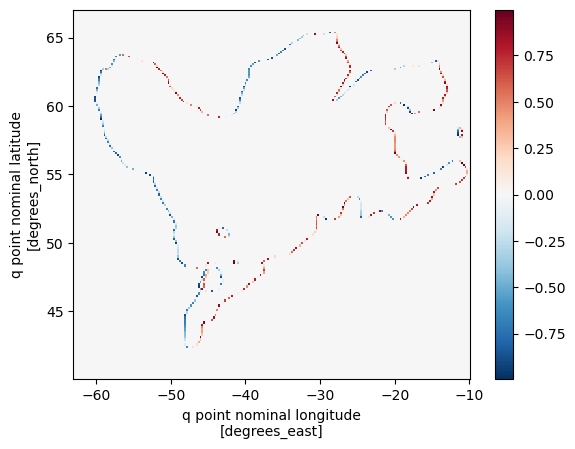

In [17]:
(mask_neg10_improved - mask_neg10_subset).plot()

## Plotting time series for area-integrated BVB terms

In [13]:
var_list = ['beta_v', 'BPT', 'curl_NL', 'curl_taus', 'curl_taub', 'curl_diff', 'mass_flux', 'curl_dudt', 'eta_dt']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

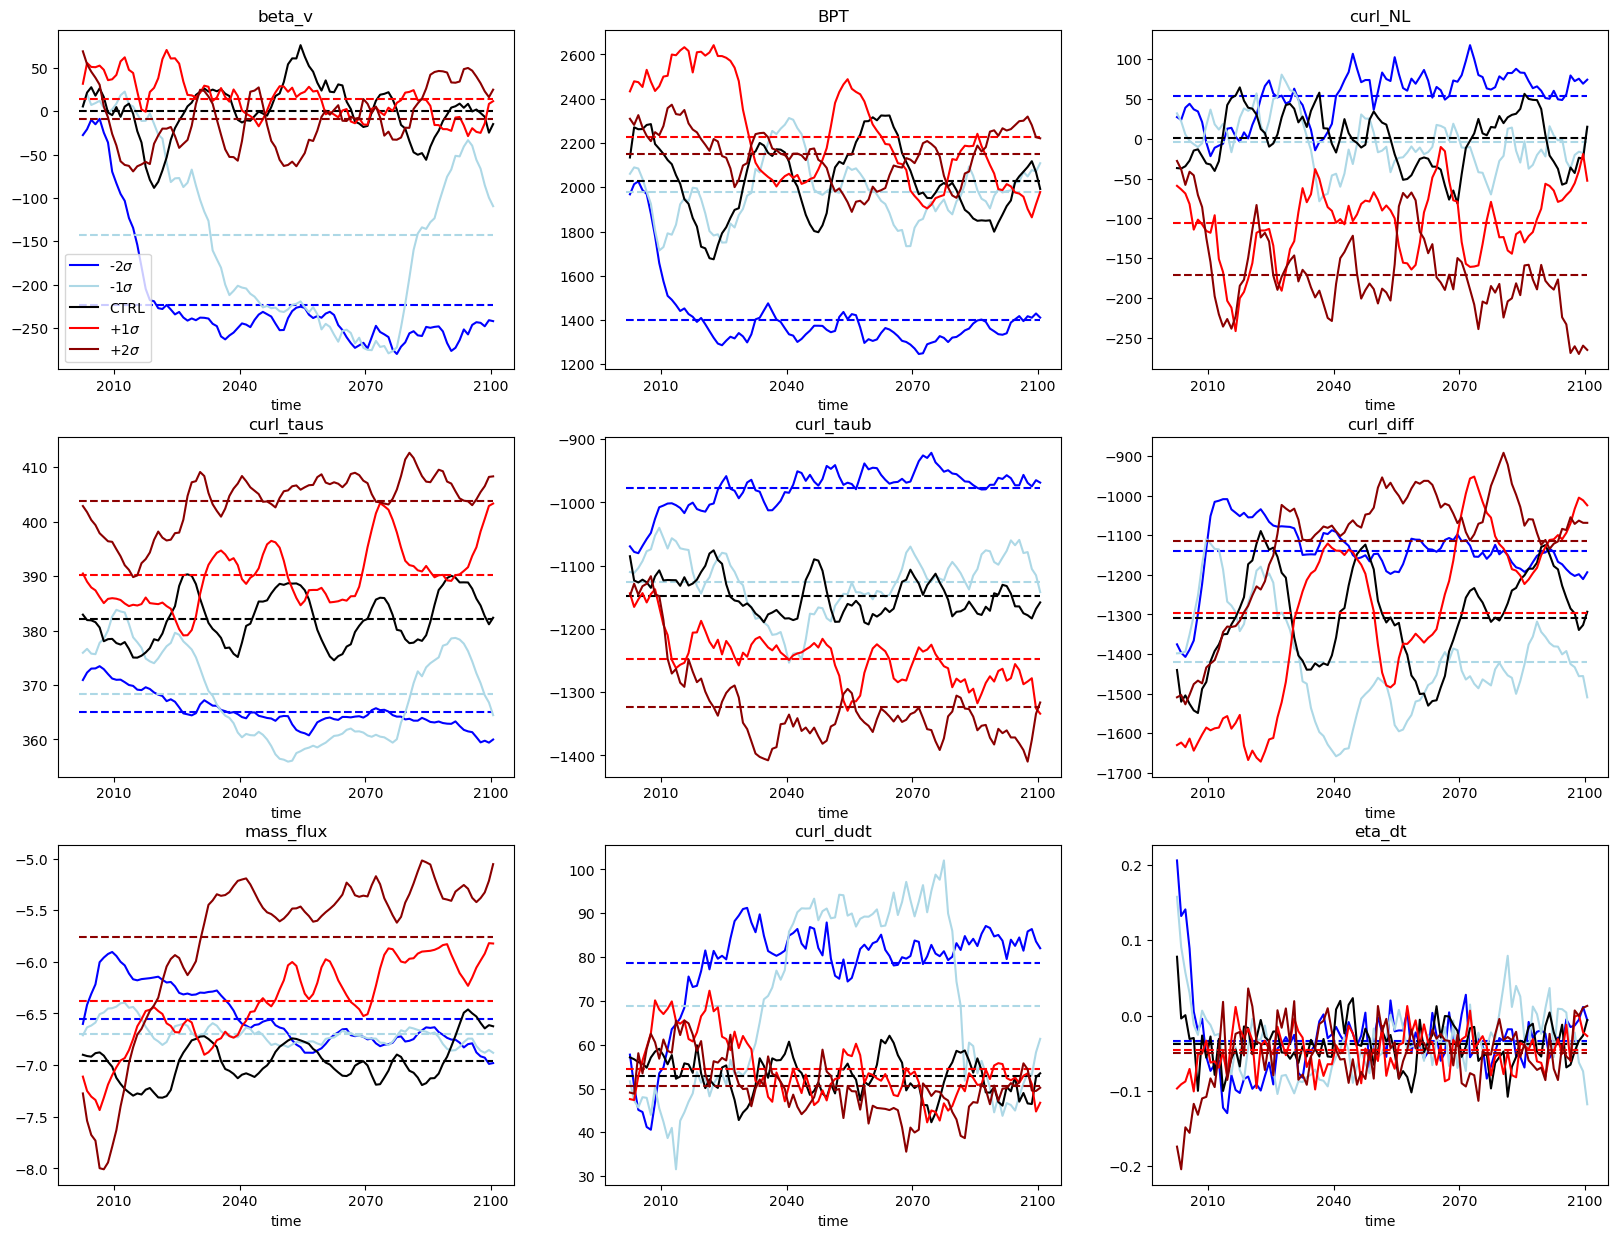

In [14]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 15))

expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

for j, expt_name in enumerate(dir_names):
    bvb_ds = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc')
    for i, var_name in enumerate(var_list):
        var = (bvb_ds[var_name] * mask_neg10_improved * area_bu_NA).sum('xq').sum('yq').coarsen(time = 12).mean()  # To check interannual variability
        var.rolling(time = 5, min_periods = 2).mean().plot(ax = axes[int(i/3)][int(i%3)], label = expt_labels[j], color = color_values[j])
        axes[int(i/3)][int(i%3)].plot(var.time, var.mean('time').values * np.ones(var.shape[0]), color = color_values[j], ls = '--')
        axes[int(i/3)][int(i%3)].set_title(var_list[i])
axes[0][0].legend()

## Decomposition into western and eastern basins

Next, we wish to decompose the subpolar gyre into western and eastern regions because they behave differently to perturbations in NAO. One dynamically consistent method is to use SSH contours. Since we are motivated to divide these two regions on dynamical arguments, we first find the boundary of western and eastern regions based on how they behave to NAO forcing perturbations. This is done in the `Snapshot-EOF-both-gyres.ipynb` notebook. Based on that, we find that SSH <= -1 metres is a good separation contour.

In [15]:
SSH = cc.querying.getvar(expt[2], 'zos', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).sel(time = slice(start_time, end_time))
SSH = grid.interp(SSH, 'Y', boundary = 'fill')
SSH = grid.interp(SSH, 'X', boundary = 'fill')
SSH_tmean_subset = SSH.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).mean('time').load()

In [16]:
SSH_cutoff_contour = -1
SSH_deep_mask = xr.where(SSH_tmean_subset >=SSH_cutoff_contour, 1, 0)
SSH_shallow_mask = xr.where(SSH_tmean_subset <SSH_cutoff_contour, 1, 0)

We use our partial masking function to ensure that SSH values close to our cutoff contour are properly accounted for.

In [17]:
western_mask = xr.where(SSH_shallow_mask + mask_neg10_improved == 2, 1, 0).load()
western_mask_improved = mask_with_interpolation(SSH_tmean_subset, western_mask, SSH_cutoff_contour, 'subpolar')
eastern_mask_improved = mask_neg10_improved - western_mask_improved

Text(0.5, 1.0, 'Eastern region')

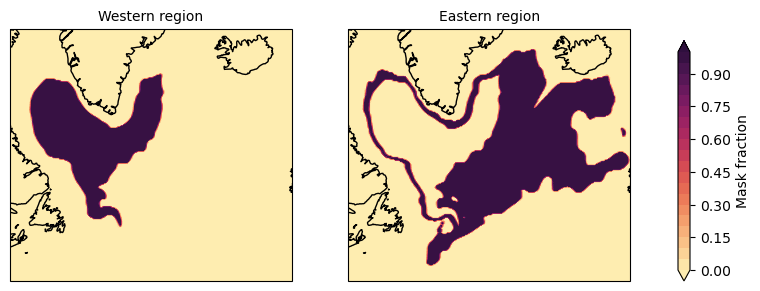

In [18]:
projection = ccrs.Mercator(central_longitude = (x_max_subpolar + x_min_subpolar)/2, min_latitude = y_min_subpolar, 
                           max_latitude = y_max_subpolar)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(western_mask_improved.xq, western_mask_improved.yq, western_mask_improved, levels = np.linspace(0, 1, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

p1 = axes[1].contourf(eastern_mask_improved.xq, eastern_mask_improved.yq, eastern_mask_improved, levels = np.linspace(0, 1, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.96, 0.18, 0.015, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Mask fraction', fontsize = 10)

for i in range(2):
    axes[i].set_extent([x_min_subpolar, x_max_subpolar, y_min_subpolar, y_max_subpolar], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')

axes[0].set_title('Western region', fontsize = 10)
axes[1].set_title('Eastern region', fontsize = 10)

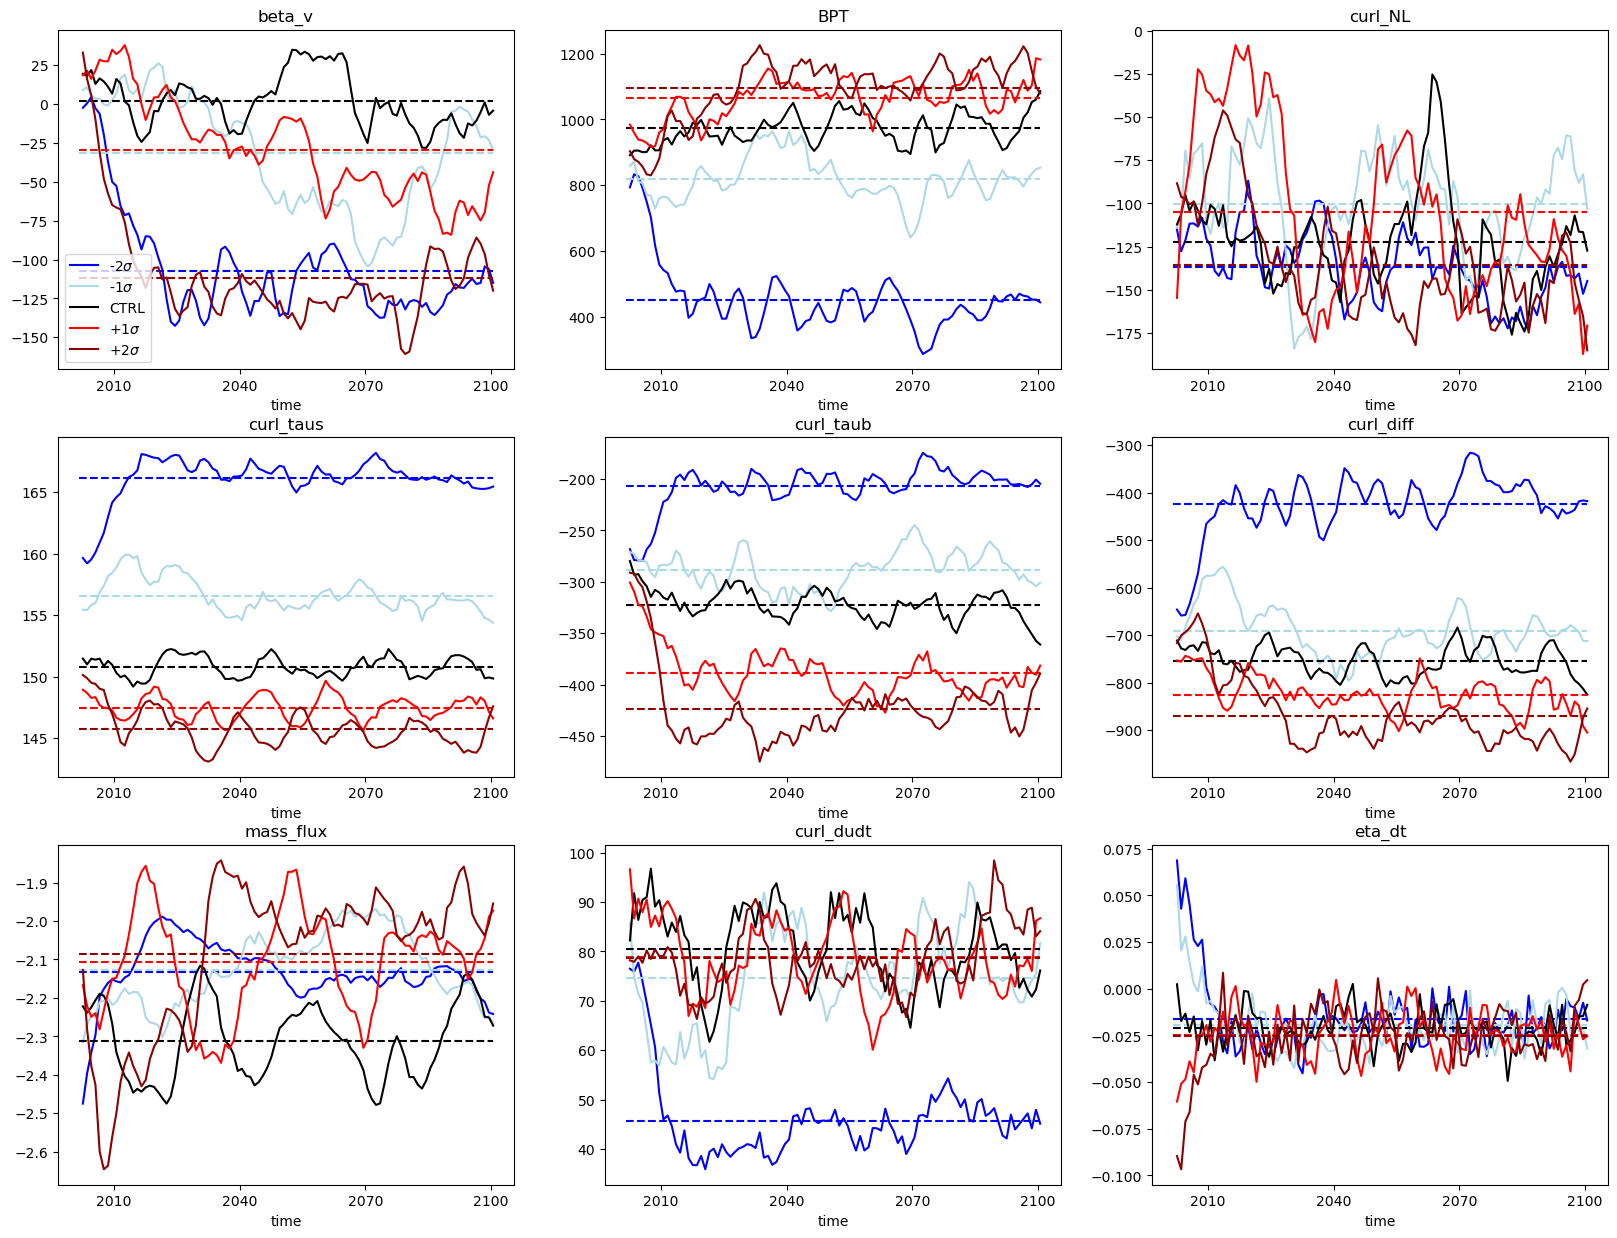

In [19]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 15))

expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

for j, expt_name in enumerate(dir_names):
    bvb_ds = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc')
    for i, var_name in enumerate(var_list):
        var = (bvb_ds[var_name] * western_mask_improved * area_bu_NA).sum('xq').sum('yq').coarsen(time = 12).mean()  # To check interannual variability
        var.rolling(time = 5, min_periods = 2).mean().plot(ax = axes[int(i/3)][int(i%3)], label = expt_labels[j], color = color_values[j])
        axes[int(i/3)][int(i%3)].plot(var.time, var.mean('time').values * np.ones(var.shape[0]), color = color_values[j], ls = '--')
        axes[int(i/3)][int(i%3)].set_title(var_list[i])
axes[0][0].legend()

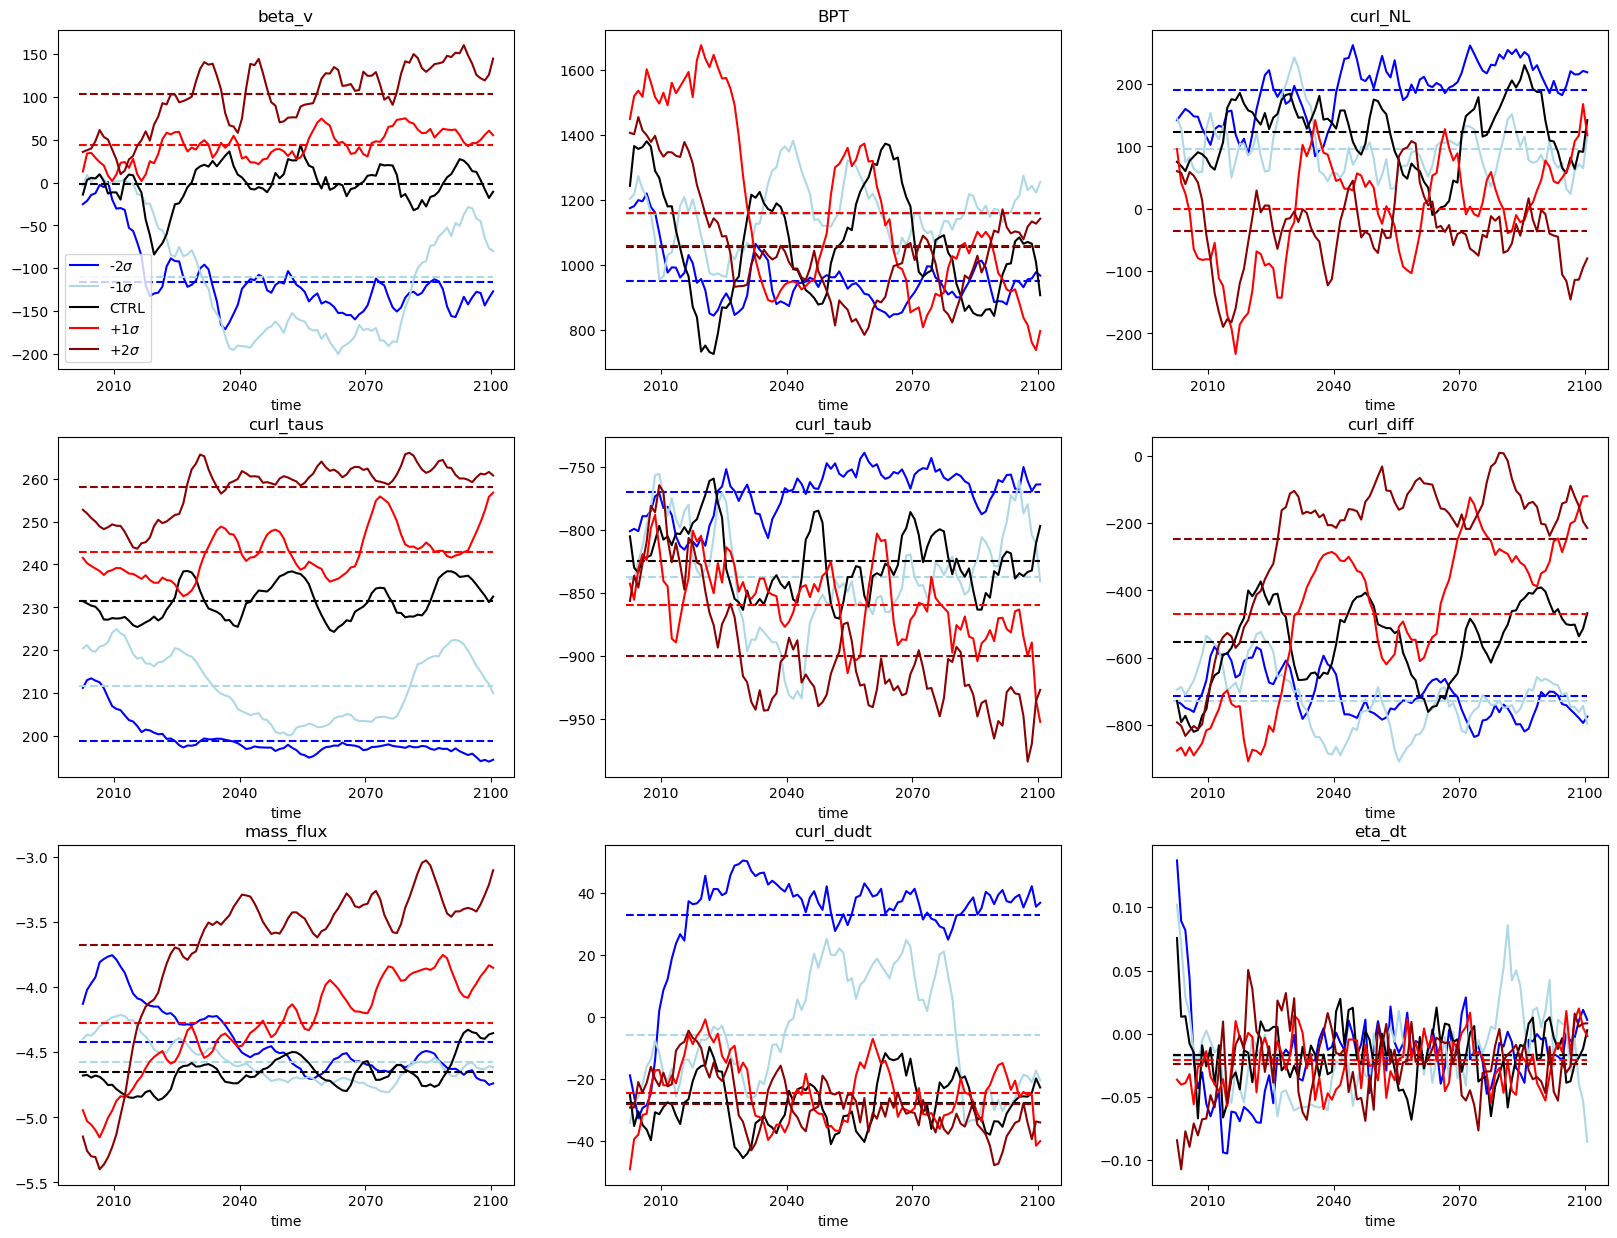

In [20]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 15))

expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

for j, expt_name in enumerate(dir_names):
    bvb_ds = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc')
    for i, var_name in enumerate(var_list):
        var = (bvb_ds[var_name] * eastern_mask_improved * area_bu_NA).sum('xq').sum('yq').coarsen(time = 12).mean()  # To check interannual variability
        var.rolling(time = 5, min_periods = 2).mean().plot(ax = axes[int(i/3)][int(i%3)], label = expt_labels[j], color = color_values[j])
        axes[int(i/3)][int(i%3)].plot(var.time, var.mean('time').values * np.ones(var.shape[0]), color = color_values[j], ls = '--')
        axes[int(i/3)][int(i%3)].set_title(var_list[i])
axes[0][0].legend()

## Decomposition based on gyre strength 

Text(0.5, 1.0, 'Barotropic streamfunction')

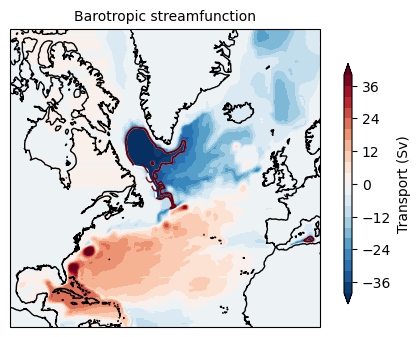

In [26]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

ϵ = 1e-5
Ψ_contour_value = -35
p1 = axes.contourf(Ψ_NA_tmean.xq, Ψ_NA_tmean.yq, Ψ_NA_tmean, levels = np.linspace(-40, 40, 21), 
            cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes.contour(Ψ_NA_tmean.xq, Ψ_NA_tmean.yq, Ψ_NA_tmean, levels = np.linspace(Ψ_contour_value - ϵ, Ψ_contour_value, 2), 
            cmap = 'Reds', transform = ccrs.PlateCarree(), extend = 'both', color = 'black')

axes.clabel(p2, levels = [Ψ_contour_value], fontsize = 12)

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Transport (Sv)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')

axes.set_title('Barotropic streamfunction', fontsize = 10)

In [27]:
cutoff_WB = -35
mask_WB = xr.where(Ψ_NA_tmean <=cutoff_WB, 1, 0).load()
mask_WB_improved = mask_with_interpolation(Ψ_NA_tmean, mask_WB, cutoff_WB, gyre_type = 'subpolar')
mask_interior_improved = (mask_neg10_improved - mask_WB_improved).load()
mask_WB_subset = xr.where(mask_WB.xq < -30, mask_WB, 0).transpose()

In [28]:
def find_last_one(arr):
    return np.array([np.max(np.where(row!=0)) if np.any(row!=0) else -1 for row in arr])

data_np = mask_WB_subset.values
last_ones = find_last_one(data_np)
last_ones_xr = xr.DataArray(last_ones, dims=["row"])

updated_data_np = data_np.copy()
updated_data_np2 = data_np.copy()
for i, last_idx in enumerate(last_ones):
    if last_idx == -1:  # If there is at least one '1' in the row
        updated_data_np2[i, :] = 1
    else:
        updated_data_np[i, :last_idx] = 1
        updated_data_np2[i, :last_idx] = 0
        updated_data_np2[i, last_idx] = 1 - data_np[i, last_idx]
        updated_data_np2[i, last_idx + 1:] = 1

# Convert the updated numpy array back to xarray DataArray
mask_WB_west = xr.DataArray(updated_data_np, dims = ["yq", "xq"], coords = 
                            [mask_WB_subset.yq, mask_WB_subset.xq])
mask_WB_east = xr.DataArray(updated_data_np2, dims = ["yq", "xq"], coords = 
                            [mask_WB_subset.yq, mask_WB_subset.xq])

mask_WB_west = xr.where((mask_neg10_improved + mask_WB_west) > 1, mask_neg10_improved, 0)
#mask_WB_east = xr.where((mask_05_improved + mask_WB_east) > 1, mask_05_improved, 0)
mask_WB_east = mask_neg10_improved - mask_WB_west

Text(0.5, 1.0, 'Eastern region')

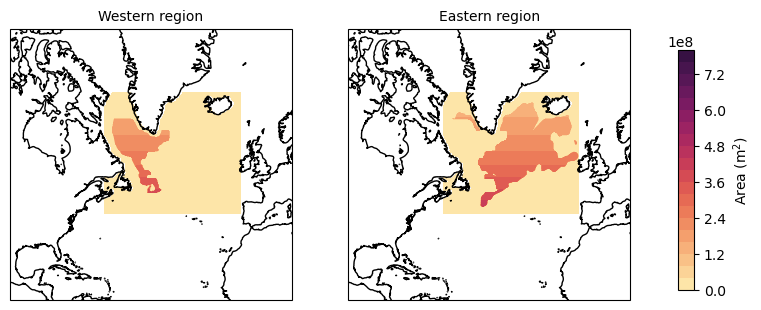

In [29]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(mask_WB_west.xq, mask_WB_west.yq, mask_WB_west * area_bu_NA, levels = np.linspace(0, 8e8, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree())
p2 = axes[1].contourf(mask_WB_east.xq, mask_WB_east.yq, mask_WB_east * area_bu_NA, levels = np.linspace(0, 8e8, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree())

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Area (m$^2$)', fontsize = 10)

for i in range(2):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')

axes[0].set_title('Western region', fontsize = 10)
axes[1].set_title('Eastern region', fontsize = 10)

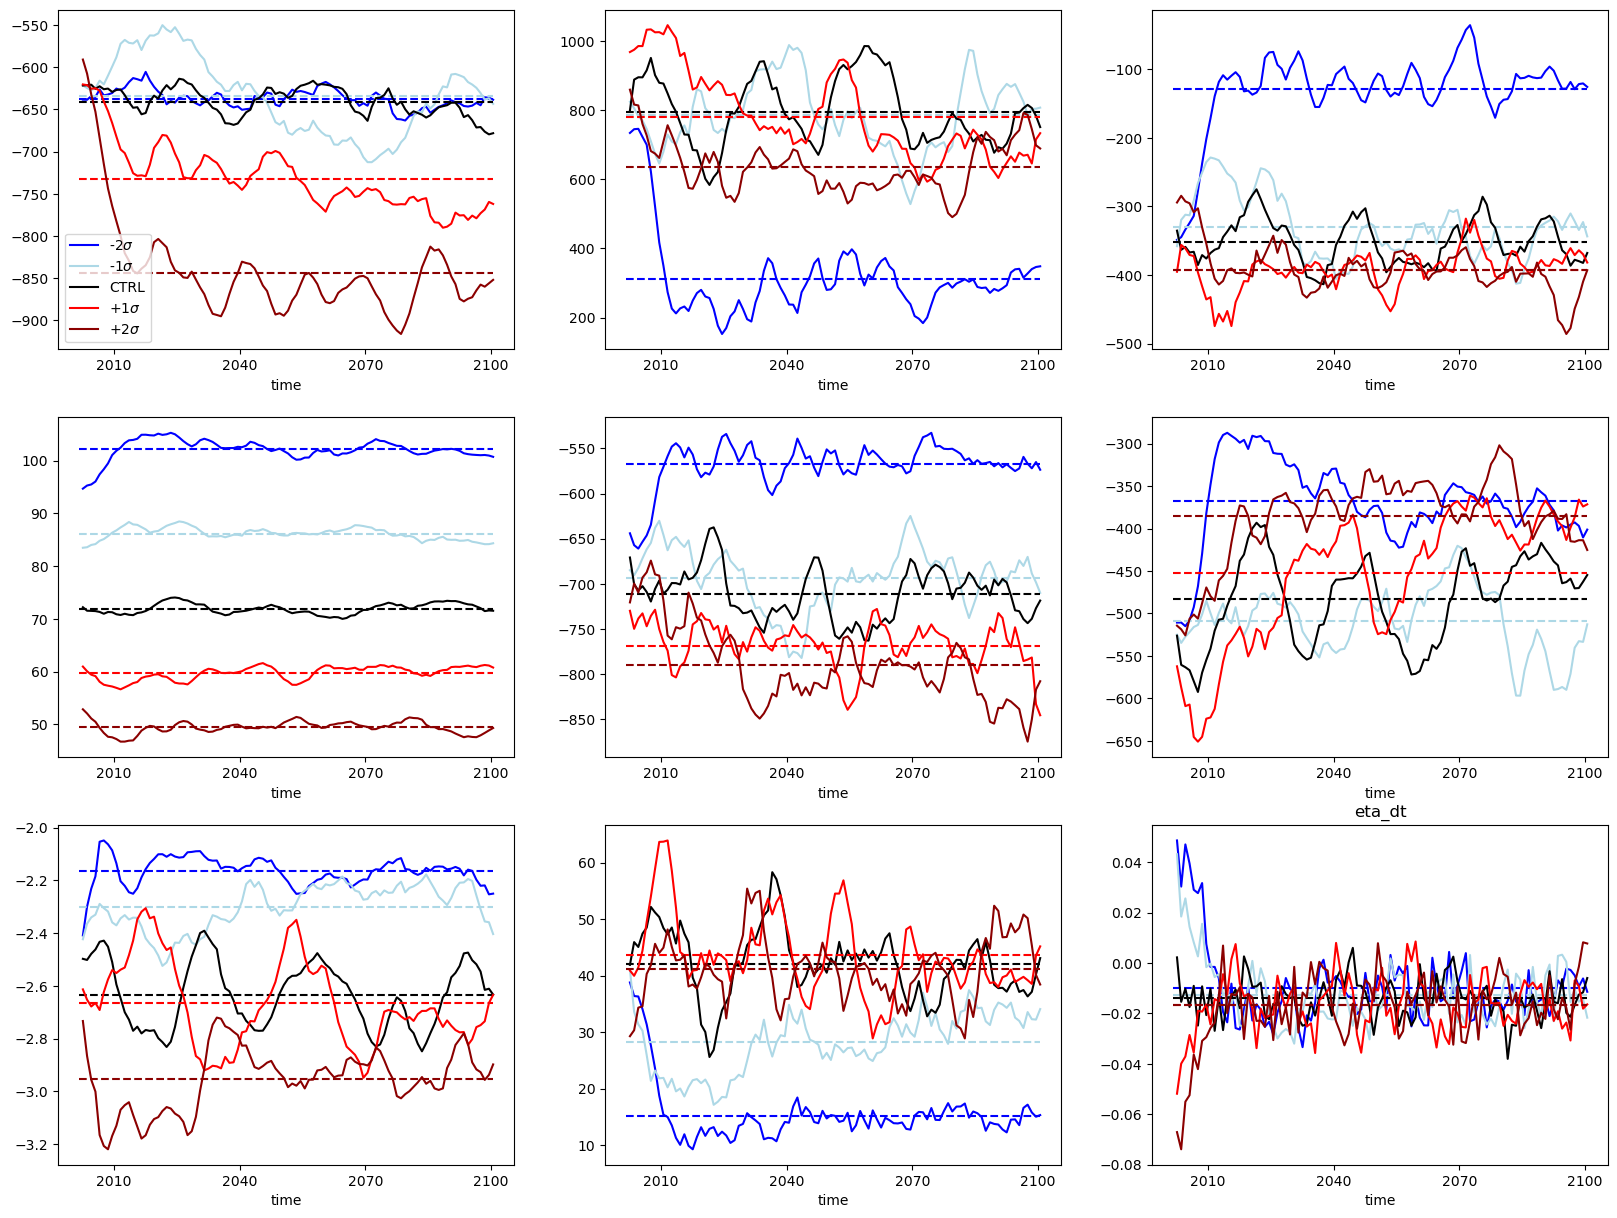

In [30]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 15))

expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

for j, expt_name in enumerate(dir_names):
    bvb_ds = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc')
    for i, var_name in enumerate(var_list):
        var = (bvb_ds[var_name] * mask_WB_west * area_bu_NA).sum('xq').sum('yq').coarsen(time = 12).mean()  # To check interannual variability
        var.rolling(time = 5, min_periods = 2).mean().plot(ax = axes[int(i/3)][int(i%3)], label = expt_labels[j], color = color_values[j])
        axes[int(i/3)][int(i%3)].plot(var.time, var.mean('time').values * np.ones(var.shape[0]), color = color_values[j], ls = '--')
        axes[int(i/3)][int(i%3)].set_title(var_list[i])
axes[0][0].legend()

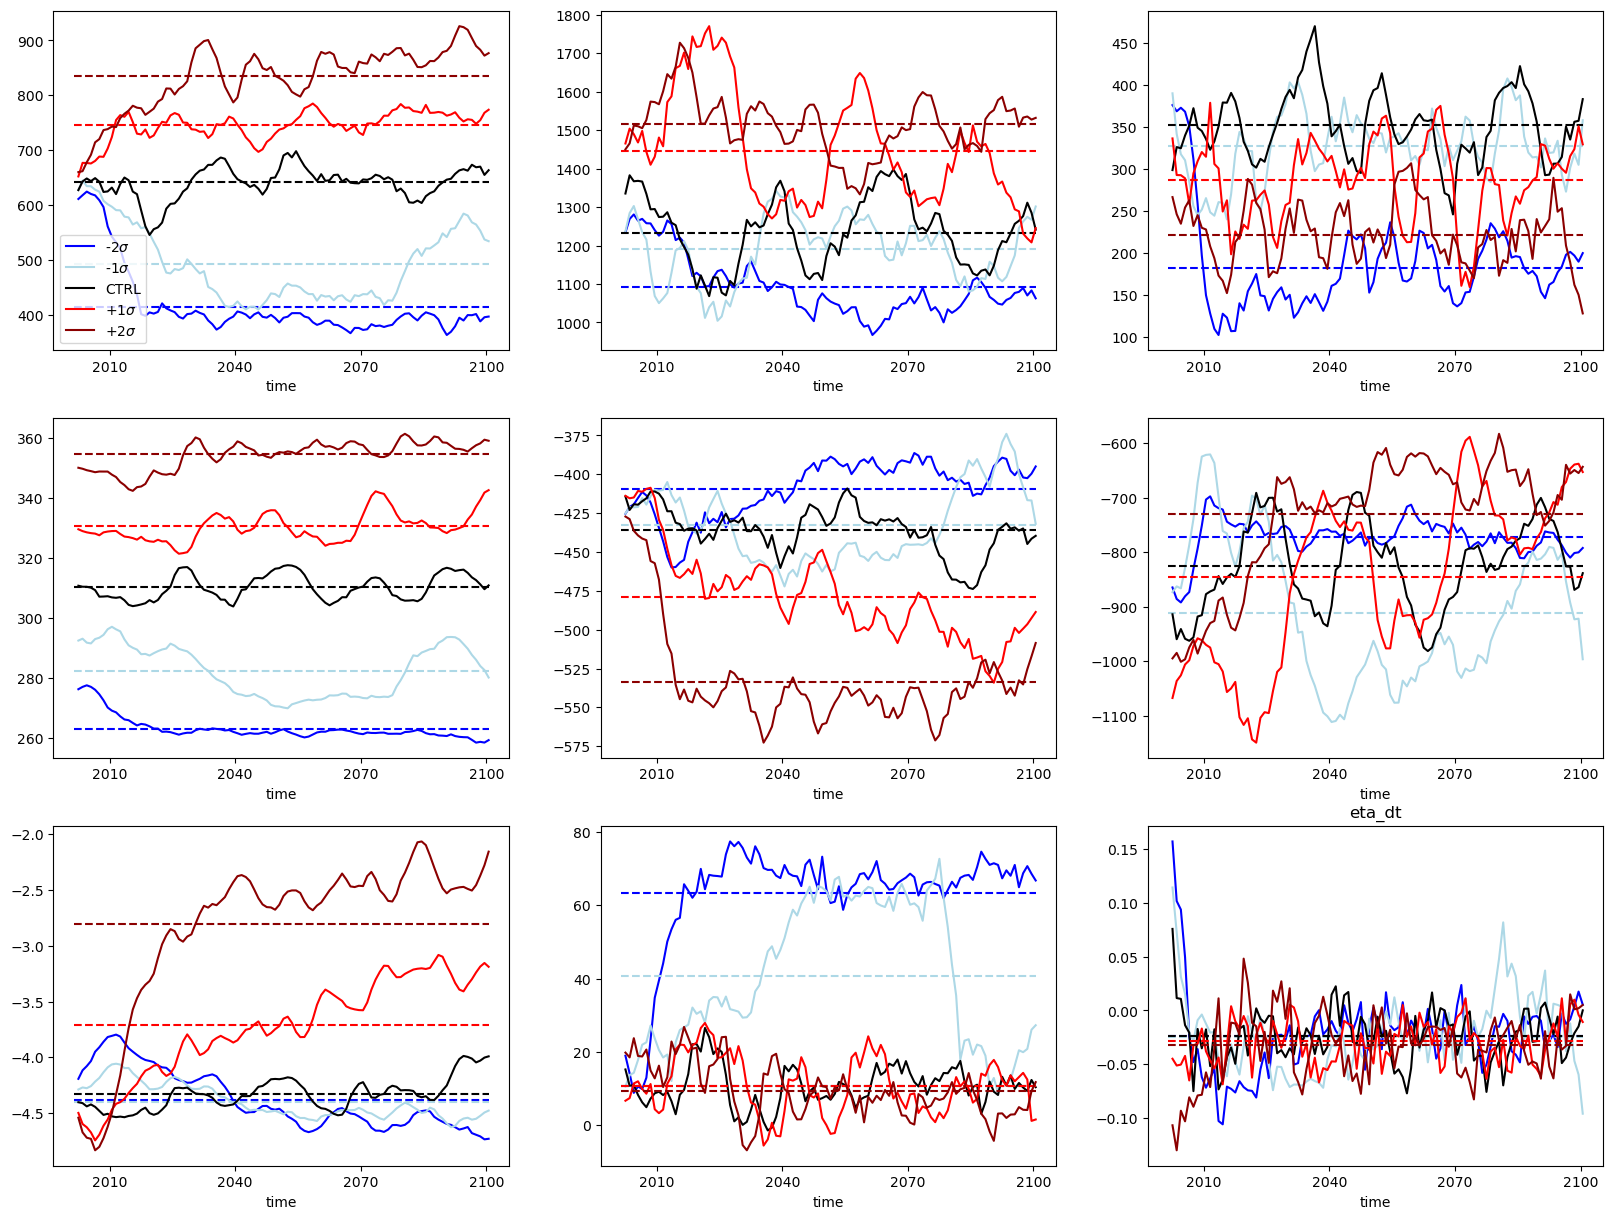

In [31]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 15))

expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

for j, expt_name in enumerate(dir_names):
    bvb_ds = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc')
    for i, var_name in enumerate(var_list):
        var = (bvb_ds[var_name] * mask_WB_east * area_bu_NA).sum('xq').sum('yq').coarsen(time = 12).mean()  # To check interannual variability
        var.rolling(time = 5, min_periods = 2).mean().plot(ax = axes[int(i/3)][int(i%3)], label = expt_labels[j], color = color_values[j])
        axes[int(i/3)][int(i%3)].plot(var.time, var.mean('time').values * np.ones(var.shape[0]), color = color_values[j], ls = '--')
        axes[int(i/3)][int(i%3)].set_title(var_list[i])
axes[0][0].legend()

## Inversely calculating gyre strength

Above, we calculated the vorticity balances by dividing the subpolar gyre into western and eastern regions. Next, we wish to calculate the gyre strength by using the modified vorticity budget equation.

In [37]:
R_earth = 6.378e6
Ω = 7.2921e-5
Ψ_base = -10e6

geolat_c = cc.querying.getvar(expt[2], 'geolat_c', session, frequency = 'static', n = 1)
dyCv = cc.querying.getvar(expt[2], 'dyCv', session, frequency = 'static', n = 1).mean('xh')
geolat_c = geolat_c.where(~np.isnan(Ψ_NA_tmean))
β = 2 * Ω * np.cos(geolat_c * np.pi /180.)/R_earth
β = (xr.where(mask_WB_west == 0, np.nan, 1) * β).mean('xq')

In [35]:
sum_west = 0
sum_west_without = 0
sum_east = 0
sum_east_without = 0

var_name = 'BPT'
vort_BPT = xr.open_dataset(base_dir + dir_names[2] + '/bvb.nc')[var_name].astype(np.float32).sel(time = slice(start_time, end_time))

for i, var_name in enumerate(var_list[1:]):
    print(i)
    var = xr.open_dataset(base_dir + dir_names[2] + '/bvb.nc')[var_name].sel(time = slice(start_time, end_time))
    sum_west = sum_west + (var * mask_WB_west * area_bu_NA).sum('xq').sum('yq').mean('time')
    sum_east = sum_east + (var * mask_WB_east * area_bu_NA).sum('xq').sum('yq').mean('time')
    var = xr.where(np.isnan(vort_BPT), np.nan, var)
    sum_west_without = sum_west_without + (var * mask_WB_west * area_bu_NA).sum('xq').sum('yq').mean('time')
    sum_east_without = sum_east_without + (var * mask_WB_east * area_bu_NA).sum('xq').sum('yq').mean('time')

0
1
2
3
4
5
6
7


In [36]:
sum_east.load()
sum_west.load()
sum_east_without.load()
sum_west_without.load()

<xarray.DataArray ()> Size: 8B
array(-641.11206803)

In [38]:
RHS1 = (sum_west/((β.dropna('yq') * dyCv).sum('yq')) + Ψ_base)/1e6
RHS2 = (-sum_east/((β.dropna('yq') * dyCv).sum('yq')) + Ψ_base)/1e6

In [39]:
RHS1.load()

<xarray.DataArray ()> Size: 8B
array(-36.44631713)

In [40]:
RHS2.load()

<xarray.DataArray ()> Size: 8B
array(-36.44758518)

In [41]:
RHS1 = (sum_west_without/((β.dropna('yq') * dyCv).sum('yq')) + Ψ_base)/1e6
RHS2 = (-sum_east_without/((β.dropna('yq') * dyCv).sum('yq')) + Ψ_base)/1e6

In [42]:
RHS1.load()

<xarray.DataArray ()> Size: 8B
array(-36.44631713)

In [43]:
RHS2.load()

<xarray.DataArray ()> Size: 8B
array(-36.44758518)

In [44]:
sum_beta_west = 0
sum_beta_west_without = 0
sum_beta_east = 0
sum_beta_east_without = 0

var_name = 'BPT'
vort_BPT = xr.open_dataset(base_dir + dir_names[2] + '/bvb.nc')[var_name].astype(np.float32).sel(time = slice(start_time, end_time))

var_name = 'beta_v'
var = xr.open_dataset(base_dir + dir_names[2] + '/bvb.nc')[var_name].sel(time = slice(start_time, end_time))
sum_beta_west = sum_beta_west + (var * mask_WB_west * area_bu_NA).sum('xq').sum('yq').mean('time')
sum_beta_east = sum_beta_east + (var * mask_WB_east * area_bu_NA).sum('xq').sum('yq').mean('time')
var = xr.where(np.isnan(vort_BPT), np.nan, var)
sum_beta_west_without = sum_beta_west_without + (var * mask_WB_west * area_bu_NA).sum('xq').sum('yq').mean('time')
sum_beta_east_without = sum_beta_east_without + (var * mask_WB_east * area_bu_NA).sum('xq').sum('yq').mean('time')

In [51]:
sum_beta_east_without.values

array(641.14280824)

In [52]:
sum_east_without.values

array(641.1428081)